# Wind Energy Production Prediction

In this notebook, the process of coming to the final model is displayed. It will also explain why we made certain decisions.

## Importing packages 

Importing the needed packages. 

In [13]:
import numpy as np
import optuna
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print(f"numpy version: {np.__version__}")
print(f"optuna version: {optuna.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"tensorflow version: {tf.__version__}")

numpy version: 2.0.2
optuna version: 4.1.0
pandas version: 2.2.3
matplotlib version: 3.10.0
scikit-learn version: 1.6.1
tensorflow version: 2.18.0


## Loading Data

In this section, we will load the cleaned dataset, which contains both weather data and wind energy production data. This dataset will be used for model training.

In [14]:
df = pd.read_csv('../data/Model/production_wind_data.csv')
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
47745,2023-06-14 10:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,456750,456750,0.207949,...,0,31,5,0,0,0,0,0,20.250000,19.384722
26140,2023-12-26 04:00:00,Nederland,Wind,Hour,UTC,Providing,Current,5653437,5653437,0.914492,...,2,79,5,0,0,0,0,0,7.608333,6.888441
42903,2022-11-24 16:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,2143000,2143000,0.975666,...,8,84,5,0,0,0,0,0,8.920833,8.575556
36559,2022-03-05 08:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,319001,319001,0.145234,...,0,73,7,0,0,0,0,0,2.608333,7.265860
9929,2022-02-18 17:00:00,Nederland,Wind,Hour,UTC,Providing,Current,66222,66222,0.014301,...,8,77,7,0,1,0,0,0,8.383333,6.836756


Since the dataset contains some offshore wind data, we will remove those entries to ensure that only mainland wind data is included. 

Offshore wind data could confuse the model since the weather data is from the center of the Netherlands(de Bilt).

In [15]:
# Select only rows where the 'type' column is 'Wind'
df = df[df['type'] == 'Wind']
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
25142,2023-11-14 14:00:00,Nederland,Wind,Hour,UTC,Providing,Current,3546214,3546214,0.580409,...,8,89,7,0,1,0,0,0,11.895833,7.799861
3054,2021-05-08 06:00:00,Nederland,Wind,Hour,UTC,Providing,Current,610728,610728,0.160944,...,8,70,5,0,0,0,0,0,10.412500,11.212500
6354,2021-09-22 18:00:00,Nederland,Wind,Hour,UTC,Providing,Current,616517,616517,0.147013,...,8,71,5,0,0,0,0,0,13.229167,15.931806
10946,2022-04-02 02:00:00,Nederland,Wind,Hour,UTC,Providing,Current,1001824,1001824,0.210695,...,8,66,5,0,0,0,0,0,2.416667,9.278333
9271,2022-01-22 07:00:00,Nederland,Wind,Hour,UTC,Providing,Current,576844,576844,0.126777,...,8,86,5,0,0,0,0,0,6.383333,5.299731


## Predictions

To start the predictions phase, we will select the features that best fit the target. This way, we give the model the best chance to accurately predict the target.

### Feature Selection

In the heatmap displayed in the EDA, we identified the columns that best correlate with the target variable. These columns will be used as features in the model.

In [16]:
# # Convert 'datetime' to datetime format and set as index
# df['datetime'] = pd.to_datetime(df['datetime'])
# df.set_index('datetime', inplace=True)

# Features and target selection
features = ['WindSpeedAvg60min', 'WindGust','WindSpeedAvg10min', 'WindDirection', 'Temperature', 'Pressure']
target = 'capacity'

Next, we will be scaling the data. Scaling the data improves the stability of the training process by ensuring that the features contribute equally during training.

In [17]:
# Scale the data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
scaled_features = feature_scaler.fit_transform(df[features])
scaled_target = target_scaler.fit_transform(df[[target]])

# Combine scaled features and target
scaled_data = np.hstack([scaled_features, scaled_target])


Next, we will be creating sequences. This step is crucial for time series forecasting as it allows the model to look back upon data from earlier time steps. By creating sequences, we enable the model to capture temporal dependencies and patterns in the data, which can significantly improve the accuracy of our predictions.

In this context, a sequence is a subset of the data that includes a specified number of previous time steps (e.g., the past 24 hours) to predict the next time step. This approach helps the model understand how past observations influence future values.

In [18]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Use past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

Next, we split the data into training and testing sets using an 80/20 split, where 80% of the data is used for training and 20% is used for testing. This ensures that the model has enough data to learn from while also having a separate set of data to evaluate its performance.

In [19]:
# # Shuffle the dataset
# X, y = shuffle(X, y, random_state=42)

# Split the dataset with a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling
To start of the modeling section. We decides to try a couple of different models and improve on the model with the most potential. 

To start off with LSTM. LSTM stands for Long Short-Term Memory. It is a deep learning model that is comparable to an ARIMA model. While ARIMA is not suited for long-term predictions beyond 6 months, LSTM is more suited for these types of time series predictions.

In [20]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


This LSTM model has 5 layers, with the last one being an output layer.

It includes:
- 2 LSTM layers: These layers contain memory cells that allow the model to maintain information over long periods. This makes the LSTM suitable for predictions over data with seasonal trends.
- 2 Dropout layers: These layers randomly drop units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data and prevents overfitting.


In [21]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.4,
    verbose=0
)

# Calculate R2 score for train data
train_predictions = model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Calculate R2 score for test data
predictions = model.predict(X_test)
test_r2 = r2_score(y_test, predictions)

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train R2 Score: 0.8550230959800457
Test R2 Score: 0.8519684598180282


so for a first model it does quite well 

In [22]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(predictions)
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

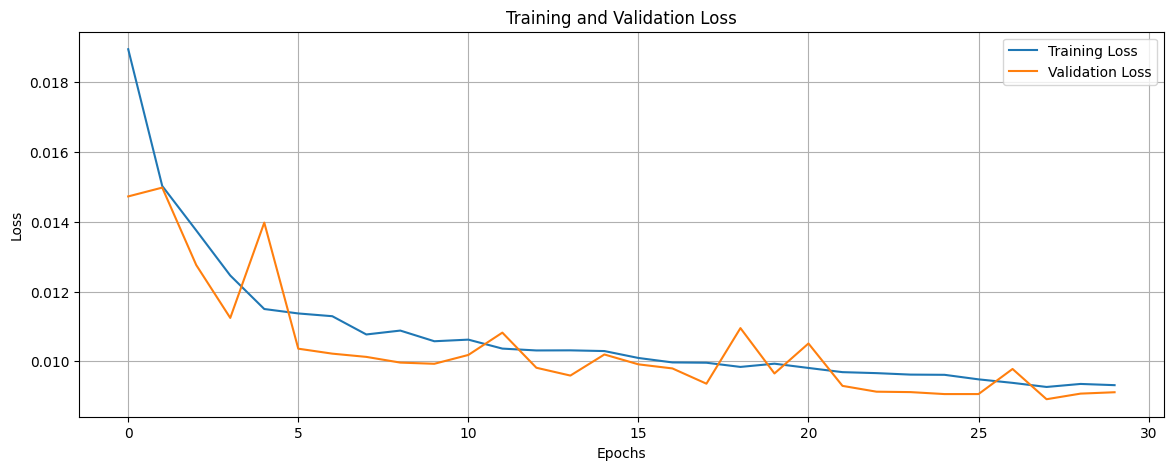

In [23]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

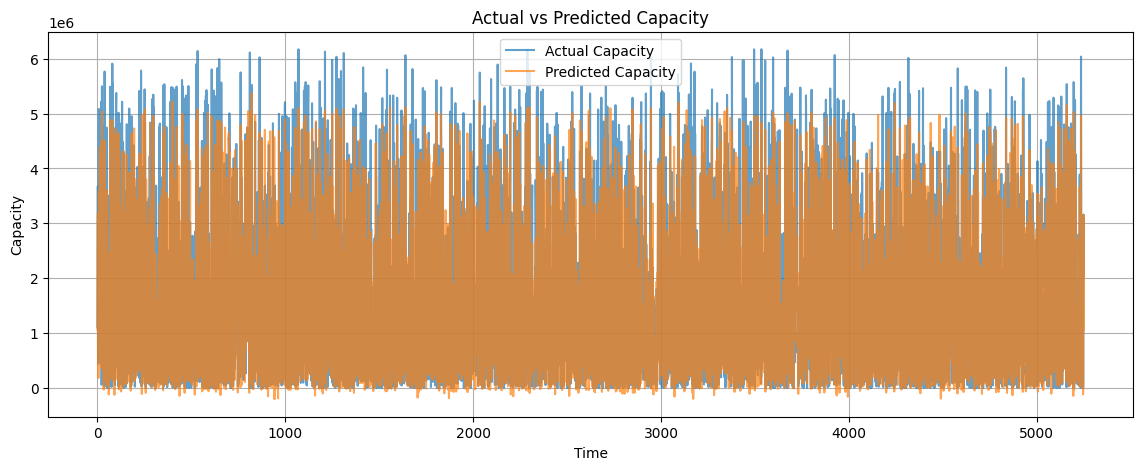

In [24]:
# Plot Predictions vs Actual Values
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()